## Backtesting
### Implicaciones sobre Órdenes Limitadas
En este cuaderno se discuten las implicaciones sobre simulaciones de estrategias de trading
que involucran órdenes limitadas y órdenes stop loss.  Las ideas generales son:
 - En las órdenes limitadas tenemos que estimar cuando se hubieran ejecutado tomando como referencia la información de precios
 - En ocasiones esta estimación es díficil porque:
     - no tenemos los datos a resolución suficiente
     - la suposición de la ejecución podría implicar un cambio en la propia definición del intervalo de precios disponibles

In [7]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from mplfinance.original_flavor import candlestick2_ohlc
import mplfinance as mpf

Velas de que que utilizaremos como ejemplo

In [9]:
fbar0 = pd.Series({
  'open': 9.50,
  'high': 10.20,
  'low': 9.45,
  'close': 9.70,
}, name=pd.to_datetime('2020-03-10'))
fbar1 = pd.Series({
  'open': 10.05,
  'high': 10.70,
  'low': 9.80,
  'close': 10.30,
}, name=pd.to_datetime('2020-03-11'))
fbar2 = pd.Series({
  'open': 9.20,
  'high': 9.50,
  'low': 9.00,
  'close': 9.05,
}, name=pd.to_datetime('2020-03-11'))


Construiremos los ejemplos suponiendo que 'observamos' la primera
vela y queremos ejecutar la orden en la segunda vela

In [10]:
example_days = pd.DataFrame([fbar0, fbar1])
example_days

,open,high,low,close
2020-03-10,9.50,10.2,9.45,9.7
2020-03-11,10.05,10.7,9.80,10.3


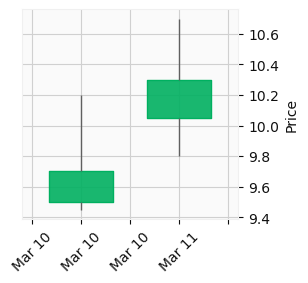

In [11]:
mpf.plot(example_days, type='candle', figsize=(3,3), style='yahoo')

## Ordenes de Compra
Si estamos simulando una orden de compra a un precio de 'entrada', el caso base sería verificar si este precio ocurre en la vela siguiente

In [12]:
precio_entrada = 10

In [13]:
def trade_ex_plot(df, target, loss=None, ax=None):
    """
    Función para representar las velas con precios de referencia
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))
    ax.axhline(target)
    if loss is not None:
        ax.axhline(loss, c='m')
    mpf.plot(df, ax=ax, type='candle', style='yahoo')

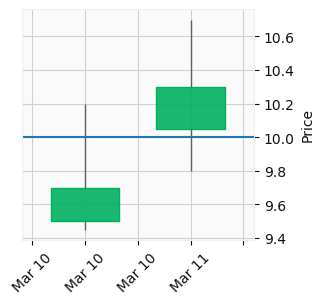

In [14]:
trade_ex_plot(example_days, precio_entrada)

In [15]:
trading_day = example_days.iloc[1]
trading_day

open     10.05
high     10.70
low       9.80
close    10.30
Name: 2020-03-11 00:00:00, dtype: float64

In [16]:
# Si ocurre en el día 
trading_day.low < precio_entrada and trading_day.high > precio_entrada

True

Sin embargo, esta suposición no es del todo realista porque una orden limitada anterior
a la vela analizada puede dar un precio de compra inferior
- en una subasta podríamos asumir que compramos al precio de apertura
- en una vela de contratación continua, nuestro bid será mejor por lo que estaríamos 'cambiando la vela' 

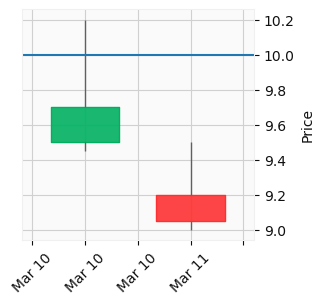

In [17]:
ex_case2 = pd.DataFrame([fbar0, fbar2])
trade_ex_plot(ex_case2, precio_entrada)

este caso en el extremo corresponde a 

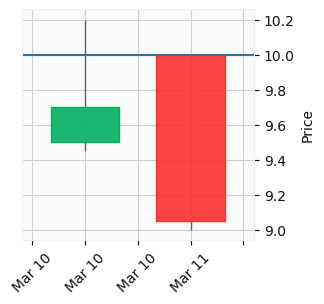

In [18]:
fbar_changed = pd.Series({'open': 10.00, 'high': 10.00, 'low': 9.00, 'close': 9.05}, 
                         name=pd.to_datetime('2020-03-11'))
ex_case3 = pd.DataFrame([fbar0, fbar_changed])
trade_ex_plot(ex_case3, precio_entrada)


In [19]:
def executable_trade(bar, price, auction=False):
    executed = bar.low < price
    real_price = None
    if executed:
        if bar.open >= price or not auction:
            real_price = price
        else: 
            real_price = bar.open
    return executed, real_price 

In [20]:
executable_trade(fbar1, precio_entrada)

(True, 10)

In [21]:
executable_trade(fbar2, precio_entrada)

(True, 10)

In [23]:
executable_trade(fbar2, precio_entrada, auction=True)

(True, 9.2)

_____

### Ordenes de Venta

Si estamos simulando una orden de venta con un precio objetivo y opcionalmente con un stop-loss,
el caso base sería verificar si el precio ocurre en la vela que estamos analizando. Sin embargo
tenemos que considerar varios casos. En aquellos en los que ambos eventos pueden ocurrir, tendremos
que hacer suposiciones de cuál de ellos ocurre primero.


#### A) Solo ocurre el precio objetivo

In [17]:
precio_salida = 10
precio_stop = 9.25

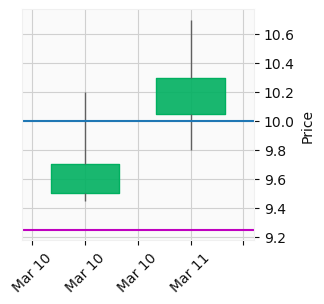

In [18]:
trade_ex_plot(example_days, precio_salida, loss=precio_stop)

- Si el precio de apertura es mayor que el precio objetivo,
podríamos asumir que vendemos al precio de apertura
- Nuestro precio objetivo sería el mejor ask, por lo que en una vela de contratación continua
podríamos estar cambiando la vela histórica. Asumir el precio objetivo es la opción más conservadora

____
#### B) Solo ocurre el precio del stop-loss

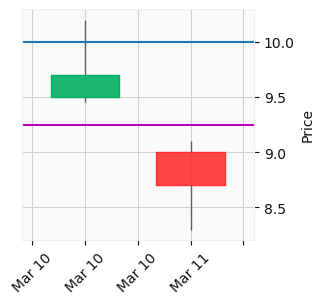

In [19]:
fbar_under = pd.Series({'open': 9.00, 'high': 9.10, 'low': 8.30, 'close': 8.70}, 
                         name=pd.to_datetime('2020-03-11'))
ex_case4 = pd.DataFrame([fbar0, fbar_under])
trade_ex_plot(ex_case4, precio_salida, loss=precio_stop)

Simular la salida con stop-loss involucra una dificultad adicional, que depende de como 
se implemente en la realidad las órdenes stop
- *Stop-loss*: Son órdenes a mercado cuando se toca el precio
    - Si el precio de apertura está por debajo del precio del stop, debemos asumir que vendemos a precio de apertura
- *Stop-limitada*: Orden limitada a un precio(inferior) cuando se toca el precio del stop
    - Si el precio de apertura está por debajo del precio límite, la orden no se ejecuta

____
#### C) Ocurren precio objetivo y stop en la vela analizada

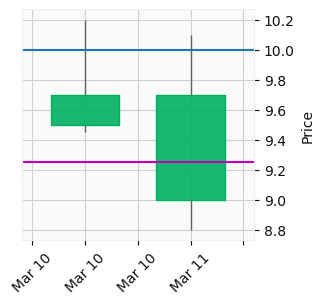

In [20]:
fbar_under = pd.Series({'open': 9.00, 'high': 10.10, 'low': 8.80, 'close': 9.70}, 
                         name=pd.to_datetime('2020-03-11'))
ex_case5 = pd.DataFrame([fbar0, fbar_under])
trade_ex_plot(ex_case5, precio_salida, loss=precio_stop)

- Si el precio de apertura ocurre por debajo del stop, el stop-loss ocurrirá primero, por lo que asumimos las condiciones en (B)

____

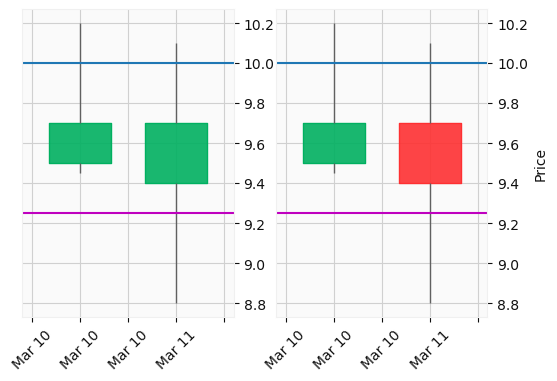

In [21]:
fbar_cup = pd.Series({'open': 9.40, 'high': 10.10, 'low': 8.80, 'close': 9.70}, 
                         name=pd.to_datetime('2020-03-11'))
ex_case6a = pd.DataFrame([fbar0, fbar_cup])
fbar_cdown = pd.Series({'open': 9.70, 'high': 10.10, 'low': 8.80, 'close': 9.40}, 
                         name=pd.to_datetime('2020-03-11'))
ex_case6b = pd.DataFrame([fbar0, fbar_cdown])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,4))
trade_ex_plot(ex_case6a, precio_salida, loss=precio_stop, ax=ax1)
trade_ex_plot(ex_case6b, precio_salida, loss=precio_stop, ax=ax2)

___

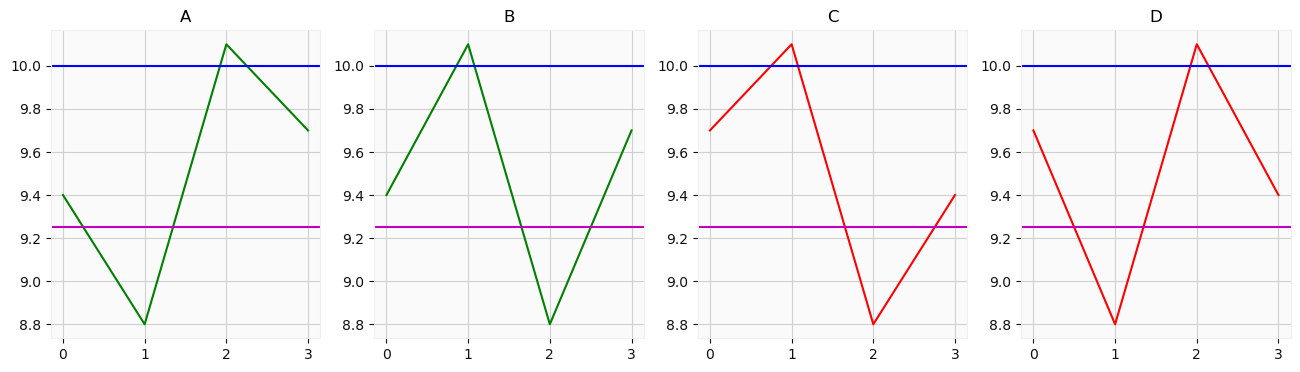

In [22]:
fix, axs = plt.subplots(1,4 , figsize=(16,4))
axs[0].plot([9.4, 8.8, 10.1, 9.7], c='g')
axs[1].plot([9.4, 10.1, 8.8, 9.7], c='g')
axs[2].plot([9.7, 10.1, 8.8, 9.4], c='r')
axs[3].plot([9.7, 8.8, 10.1, 9.4], c='r')
for ax, nl in zip(axs, ['A','B','C','D']):
    ax.axhline(precio_salida, c='b')
    ax.axhline(precio_stop, c='m')
    ax.set_title(nl)

#### Analizamos en detalle las posibilidades
Con la información de la vela, no podemos saber a priori si el máximo ha ocurrido antes que el mínimo.  
- En la vela verde, (A) parece más probable que el mínimo ocurra antes, porque sino esto implica más recorrido del precio (B).
- En la vela roja, (C) parece más probable, donde el máximo ocurren antes, porque (D) implica más recorrido de precio

Sin embargo cualquiera de las suposiciones afectaría directamente a la evaluación de un backtesting.  Como alternativas tenemos:
   1. Utilizar datos de resolución más baja para aproximar mejor el evento que ocurre primero
   2. Hacer una **estimación de la proporción** de casos y hacer una selección aleatoria siguiendo esa proporción